## Summary
(1) If we have a tensor that stores data, we can use torch.utils.data.TensorDataset to create a dataset.   
(2) For manual implementation of linear regression, the key is the operations in for each batch. We get the prediction of the batch first, which is then used for calculating the loss. During these calculations, the connection between the loss and the model parameters are automatically constructed (the computation graph) by pytorch. Then we can use the backward function to find the derivatives, which is used to update parameters. Finally, we need to set the gradients to zeros for the next batch.   
(3) For pytorch implementation of linear regression, we don't need to define the linear model and the loss function by ourselves. Instead, we use existing functions. Also, we do not manually implement gradient descent. We use an optimizer function to do this.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [36]:
# Create a toy dataset
# Create feature data X_train
# Note that the array is reshaped into a column vector.
# Later on, we will use torch.from_numpy to convert this column vector into a tensor.
# torch.from_numpy will keep the shape of the array. Thus we will get a tensor with a single column
# This is required by pytorch, because in feature data should be stored such that each row corresponds to a single example
# On the other hand, there is no need to reshape the label data y_train. 
# By concention, pytorch use 1D tensor for the labels.
X_train = np.arange(10, dtype='float32').reshape(10, 1)
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0], dtype='float32')

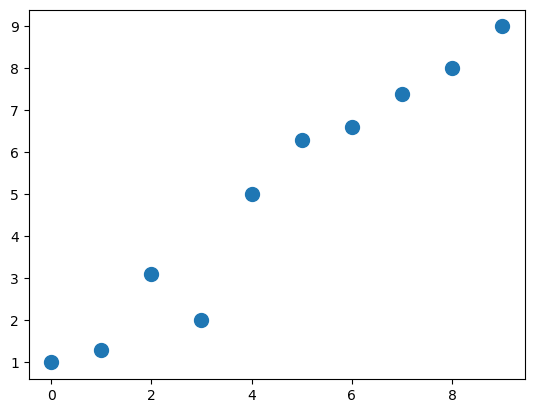

In [37]:
# Visualize the dataset
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_train, y_train, marker='o', s=100)

In [39]:
# Normalizing the data
# ??? Do not quite understand why normalization is necessary.
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
# Create a torch tensor for the features
X_train_norm_tensor = torch.from_numpy(X_train_norm)
# Create a torch tensor for the labels
y_train_tensor = torch.from_numpy(y_train)

In [40]:
# Create a dataset and a dataloader
# Note that we can directly use an existing function in pytorch, TensorDataset, rather than define a dataset class by ourselves.
# This is because we have a tensor at hand.
ds_train = torch.utils.data.TensorDataset(X_train_norm_tensor, y_train_tensor)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=1, shuffle=True)

In [41]:
# Define a linear regression model
# Initialize the weight with a random number.
torch.manual_seed(1)
weight = torch.randn(1)
# Since we need the gradient of the loss wrt weights, we require the weight tensor to store their gradients
weight.requires_grad_()
# This is another way of claiming the requirement for gradients
bias = torch.zeros(1, requires_grad=True)
def model(xb):
    # @: this is short-handed way of torch.matmul()
    return xb @ weight + bias


In [42]:
# Define a loss function
def loss_fn(prediction, target):
    # both prediction and target are vectors
    # Therefore, there is a mean() at the end
    return (prediction-target).pow(2).mean()

In [43]:
# Implementing linear regression manually
learning_rate = 0.001
num_epoch = 200
log_epoch = 10 # Use to print the current loss during iteration
for epoch in range(num_epoch):
    for x_batch, y_batch in dl_train:
        # This is the same as torch.matmul(x_batch, weight) + bias
        pred = model(x_batch)
        # Calculate the loss
        loss = loss_fn(pred, y_batch)
        # Calculate the gradient of the loss wrt weight and bias
        # The partial derivatives are stored alongside with weight and bias
        loss.backward()
    # 'with torch.no_grad():' start a code block where gradient computation is disabled
    with torch.no_grad():
        # weight.grad: partial Loss partial weight
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        # This sets the gradients of a tensor to zero
        # ChatGPT: In PyTorch, when we call backward() on a tensor x, 
        # the gradients of x are accumulated in the x.grad attribute. 
        # This means that if we don't reset the gradients to zero 
        # before computing the gradients for a new batch or sample, 
        # the gradients will be accumulated across multiple iterations 
        # and lead to incorrect gradients and training. 
        # Therefore, it is important to reset the gradients 
        # before computing the gradients for a new batch or sample.
        weight.grad.zero_()
        bias.grad.zero_()
    if epoch % log_epoch ==0:
        print(f"Epoch {epoch} Loss {loss.item()}")

Epoch 0 Loss 46.57198715209961
Epoch 10 Loss 27.150222778320312
Epoch 20 Loss 1.6445956230163574
Epoch 30 Loss 14.45706844329834
Epoch 40 Loss 11.78266429901123
Epoch 50 Loss 6.412241458892822
Epoch 60 Loss 0.6338688135147095
Epoch 70 Loss 3.1561715602874756
Epoch 80 Loss 2.010047197341919
Epoch 90 Loss 0.3107231855392456
Epoch 100 Loss 0.7625206112861633
Epoch 110 Loss 1.0023512840270996
Epoch 120 Loss 0.023156199604272842
Epoch 130 Loss 0.5138028860092163
Epoch 140 Loss 0.0741419717669487
Epoch 150 Loss 1.871219277381897
Epoch 160 Loss 0.0006759515963494778
Epoch 170 Loss 0.08502652496099472
Epoch 180 Loss 0.06339222192764282
Epoch 190 Loss 0.0012209871783852577


In [44]:
# Show fitted parameters
# weight.item extracts the scalar from the weight tensor
print("Weight:", weight.item())
print("bias:", bias.item())

Weight: 2.670930862426758
bias: 4.88258695602417


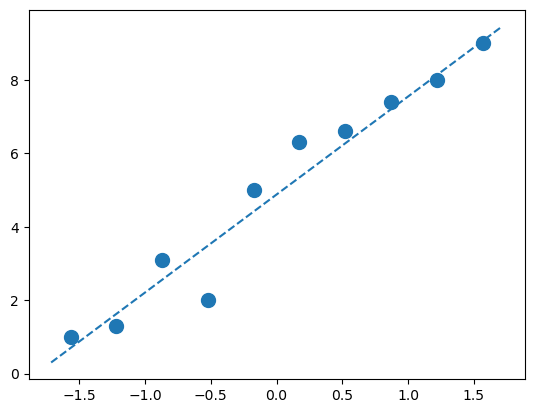

In [45]:
# Visualization
X_test = np.linspace(0, 9, 100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)
X_test_norm_tensor = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm_tensor).detach().numpy()
# detach() creates a new tensor that copy the original tensor without its gradient.



fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_train_norm_tensor, y_train_tensor, marker='o', s=100)
ax.plot(X_test_norm_tensor, y_pred, linestyle="--")

## Using existing functions

In [46]:
# Loss function, see below for more explanations
loss_fn = torch.nn.MSELoss(reduction='mean')
# Linear model, see below for more explanations
model = torch.nn.Linear(in_features=1, out_features=1)
# Stochastic gradient descent
# We need to provide at least two arguments: model parameters and learning rate
# The model parameters are specified via model.parameters()
# model.parameters() returns an iterator over the model's parameters.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [47]:
# Try a different batch size
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=2, shuffle=True)

I tried different batch sizes. It seems that batch_size=1 is the best.

In [48]:
num_epoch = 200
log_epoch = 10
for epoch in range(num_epoch):
    for x_batch, y_batch in dl_train:
        pred = model(x_batch)[:, 0] # See explanations below for why using [:,0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % log_epoch ==0:
        print(f"Epoch {epoch} Loss {loss.item()}")

Epoch 0 Loss 43.43412780761719
Epoch 10 Loss 20.916259765625
Epoch 20 Loss 15.00023078918457
Epoch 30 Loss 0.22231706976890564
Epoch 40 Loss 24.636737823486328
Epoch 50 Loss 18.813777923583984
Epoch 60 Loss 24.533966064453125
Epoch 70 Loss 11.496208190917969
Epoch 80 Loss 3.2024848461151123
Epoch 90 Loss 6.5843071937561035
Epoch 100 Loss 6.808850288391113
Epoch 110 Loss 8.456554412841797
Epoch 120 Loss 1.774774432182312
Epoch 130 Loss 0.19836652278900146
Epoch 140 Loss 2.518380880355835
Epoch 150 Loss 1.635271430015564
Epoch 160 Loss 1.3537408113479614
Epoch 170 Loss 0.4487612843513489
Epoch 180 Loss 1.6394603252410889
Epoch 190 Loss 0.7331166863441467


In [49]:
print("Weight:", model.weight.item())
print("Bias:", model.bias.item())

Weight: 2.281066417694092
Bias: 4.282294273376465


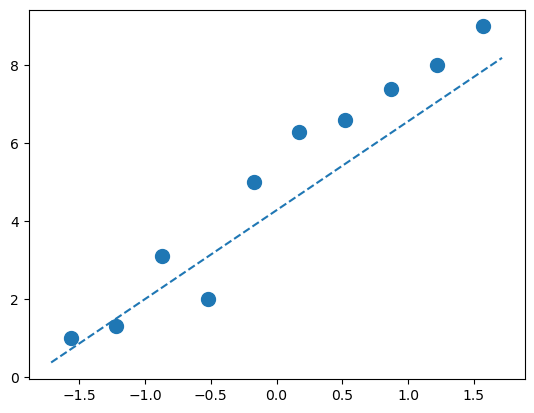

In [50]:
# Visualization
X_test = np.linspace(0, 9, 100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)
X_test_norm_tensor = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm_tensor).detach().numpy()
# detach() creates a new tensor that copy the original tensor without its gradient.

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_train_norm_tensor, y_train_tensor, marker='o', s=100)
ax.plot(X_test_norm_tensor, y_pred, linestyle="--")

## More explanations on the above implementation

In [51]:
# Loss function
# Use torch.nn.MSELoss to create a loss function
# This loss takes tensors as inputs

# Predictions
pred = torch.tensor([1.,2.,3.])
# Target labels
label = torch.tensor([2.,3.,4.])
# Create a loss function
mse_loss = torch.nn.MSELoss()
# Print the calculated loss
print("Loss:", mse_loss(pred, label))

Loss: tensor(1.)


In [52]:
# More options on torch.nn.MSELoss

# The default setting: the loss is an average of squared difference
mse_loss = torch.nn.MSELoss(reduction='mean')
print("Loss_mean:", mse_loss(pred, label))

# Sum the squares without taking average
mse_loss = torch.nn.MSELoss(reduction='sum')
print("Loss_sum:", mse_loss(pred, label))

# Generate individual squares
mse_loss = torch.nn.MSELoss(reduction='none')
print("Loss_none:", mse_loss(pred, label))

Loss_mean: tensor(1.)
Loss_sum: tensor(3.)
Loss_none: tensor([1., 1., 1.])


In [53]:
# Linear transformation
linear_model = torch.nn.Linear(in_features=2, out_features=1)
print("Weight:", linear_model.weight)
print("Bias:", linear_model.bias)

Weight: Parameter containing:
tensor([[0.6230, 0.6594]], requires_grad=True)
Bias: Parameter containing:
tensor([-0.4158], requires_grad=True)


In [54]:
linear_model = torch.nn.Linear(in_features=3, out_features=2)
print("Weight:", linear_model.weight)
print("Bias:", linear_model.bias)

Weight: Parameter containing:
tensor([[-0.0199,  0.5754, -0.3748],
        [-0.0904, -0.3962,  0.4166]], requires_grad=True)
Bias: Parameter containing:
tensor([0.0936, 0.2403], requires_grad=True)


In [55]:
linear_model = torch.nn.Linear(in_features=1, out_features=1)
print("Weight:", linear_model.weight)
print("Bias:", linear_model.bias)

Weight: Parameter containing:
tensor([[0.7176]], requires_grad=True)
Bias: Parameter containing:
tensor([-0.1587], requires_grad=True)


From the above results, we can see that the weight is a matrix (2D tensor) and the bias is a vector (1D tensor). Even when input and output are both scalars, the dimensions of the weight and bias remain unchanged. This is for consistency. 

In [56]:
# When the weight and bias are scalars, we can extract these values by .item()
linear_model = torch.nn.Linear(in_features=1, out_features=1)
print("Weight:", linear_model.weight.item())
print("Bias:", linear_model.bias.item())

Weight: -0.9995875358581543
Bias: 0.04896879196166992


ChatGPT: The nitialization of the weight and bias is done by the Xavier initialization (the Glorot initialization).

In [57]:
# Stochastic gradient descent
# Explanation of a single epoch

# Again, we define the loss function, the linear model, the optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
model = torch.nn.Linear(in_features=1, out_features=1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [58]:
# Create a dataset and a dataloader
ds_train = TensorDataset(X_train_norm_tensor, y_train_tensor)
dl_train = DataLoader(ds_train, batch_size=1, shuffle=True)

In [59]:
# Show the result of a single epoch
num_epoch = 1
for epoch in range(num_epoch):
    for x_batch, y_batch in dl_train:
        print(x_batch)
        pred = model(x_batch)
        print(pred)

tensor([[-1.2185]])
tensor([[0.4570]], grad_fn=<AddmmBackward0>)
tensor([[-0.1741]])
tensor([[0.3761]], grad_fn=<AddmmBackward0>)
tensor([[0.1741]])
tensor([[0.3492]], grad_fn=<AddmmBackward0>)
tensor([[1.5667]])
tensor([[0.2414]], grad_fn=<AddmmBackward0>)
tensor([[0.5222]])
tensor([[0.3223]], grad_fn=<AddmmBackward0>)
tensor([[-0.8704]])
tensor([[0.4300]], grad_fn=<AddmmBackward0>)
tensor([[-1.5667]])
tensor([[0.4839]], grad_fn=<AddmmBackward0>)
tensor([[-0.5222]])
tensor([[0.4031]], grad_fn=<AddmmBackward0>)
tensor([[0.8704]])
tensor([[0.2953]], grad_fn=<AddmmBackward0>)
tensor([[1.2185]])
tensor([[0.2684]], grad_fn=<AddmmBackward0>)


We can see that the result 'pred' is a 2D tensor, even if each time a single value is fed to the model.

In [60]:
# Use a different batch size
dl_train = DataLoader(ds_train, batch_size=2, shuffle=True)

In [61]:
# Show the result of a single epoch
num_epoch = 1
for epoch in range(num_epoch):
    for x_batch, y_batch in dl_train:
        print(x_batch)
        pred = model(x_batch)
        print(pred)

tensor([[1.2185],
        [0.8704]])
tensor([[0.2684],
        [0.2953]], grad_fn=<AddmmBackward0>)
tensor([[-1.5667],
        [ 0.1741]])
tensor([[0.4839],
        [0.3492]], grad_fn=<AddmmBackward0>)
tensor([[-0.5222],
        [-1.2185]])
tensor([[0.4031],
        [0.4570]], grad_fn=<AddmmBackward0>)
tensor([[1.5667],
        [0.5222]])
tensor([[0.2414],
        [0.3223]], grad_fn=<AddmmBackward0>)
tensor([[-0.8704],
        [-0.1741]])
tensor([[0.4300],
        [0.3761]], grad_fn=<AddmmBackward0>)


Now we can see that each input is a 2D column vector. The output 'pred' is also a 2D column vector. Thus, we can see that in the previous case, even we fed the model with a single value each time, the single value was regarded as a 2D column vector with a single entry.

In [62]:
# y_batch is a 1D tensor
print(y_batch)

tensor([3.1000, 5.0000])


In [63]:
# The dimensions of pred and y_batch do not match, so there is a warning when first executing the code
print(pred)
print(y_batch)
loss = loss_fn(pred, y_batch)
print(loss)

tensor([[0.4300],
        [0.3761]], grad_fn=<AddmmBackward0>)
tensor([3.1000, 5.0000])
tensor(14.2032, grad_fn=<MseLossBackward0>)


C:\Users\bai_f\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [64]:
# Now we use indexing to get convert pred into a 1D tensor
pred = model(x_batch)[:, 0]
print(pred)

tensor([0.4300, 0.3761], grad_fn=<SelectBackward0>)


In [65]:
# Now we calculate loss again. This time the two dimensions match.
loss = loss_fn(pred, y_batch)
print(loss)

tensor(14.2544, grad_fn=<MseLossBackward0>)


In [66]:
# Backward propagation to get partial derivatives
loss.backward()
# This fulfills gradient descent
optimizer.step()
# This sets gradient to zero, which is necessary for training for multiple epochs
optimizer.zero_grad()
